In [143]:
import os
from typing import Optional

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl

from PIL import Image

from matplotlib import pyplot as plt

In [144]:
DATA_DIR = 'data\Abstract_gallery'
CHECKPOINTS_DIR = 'checkpoints'
GENERATED_IMGS_DIR = 'generated_imgs'
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 64
IMAGE_CHANNELS = 3
LATENT_SIZE = 256
EPOCHS = 20
NUM_WORKERS = 0
random_seed = 42
torch.manual_seed(random_seed)

In [145]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [146]:
def show_images(image_tensor,
                       num_images=25,
                       size=(3, 64, 64),
                       ret=False):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [147]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [148]:
def get_noise(cur_batch_size, z_dim):
    noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
    return noise

In [149]:
class AbstractGalleryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len([image for image in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, image))])

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, os.listdir(self.root_dir)[index])
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

In [150]:
class AbstractGalleryDataModule(pl.LightningDataModule):
    def __init__(self, data_dir=DATA_DIR, batch_size=BATCH_SIZE):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [
                transforms.Resize(IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )

    def setup(self, stage: Optional[str] = None):
        df = AbstractGalleryDataset(DATA_DIR, transform=self.transform)
        self.train, self.test = random_split(df, [1950, 832])

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=NUM_WORKERS)

In [151]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            # n x latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 64 * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # n x 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # n x 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # n x 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # n x 64 x 32 x 32
            nn.ConvTranspose2d(64, IMAGE_CHANNELS, kernel_size=4, stride=2, padding=1),
            # n x IMAGE_CHANNELS x 64 x 64
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [152]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # n x IMAGE_CHANNELS x 64 x 64
            nn.Conv2d(IMAGE_CHANNELS, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # n x 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2),
            # n x 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2),
            # n x 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2),
            # n x 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, kernel_size=4, stride=1, padding=0),
            # n x 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, x):
        pred = self.model(x)
        return pred.view(len(pred), -1)

In [153]:
class DCGAN(pl.LightningModule):
    def __init__(self, lr=0.0002, latent_dim=100, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

    def forward(self, z):
        return  self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def generator_step(self, x, z):
        fake_imgs = self.generator(z)

        y_hat_fake = self.discriminator(fake_imgs)

        generator_loss = self.adversarial_loss(y_hat_fake, torch.ones_like(y_hat_fake))
        self.log('generator_loss', generator_loss, prog_bar=True, sync_dist=True)
        return generator_loss

    def discriminator_step(self, x, z):
        fake_imgs = self.generator(z)

        y_hat_real = self.discriminator(x)
        y_hat_fake = self.discriminator(fake_imgs.detach())

        real_loss = self.adversarial_loss(y_hat_real, torch.ones_like(y_hat_real))
        fake_loss = self.adversarial_loss(y_hat_fake, torch.ones_like(y_hat_fake))
        discriminator_loss = (real_loss + fake_loss) / 2
        self.log('discriminator_loss', discriminator_loss, prog_bar=True, sync_dist=True)
        return discriminator_loss

    def training_step(self, batch, batch_idx, optimizer_idx):
        x = batch
        x = real_imgs = x.to(device)

        # sample noise
        z = get_noise(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        if batch_idx % 200 == 0 and optimizer_idx == 0:
            fake_images = self.forward(z)
            show_images(fake_images)

        loss = 0.0
        if optimizer_idx == 0:
            loss = self.generator_step(real_imgs, z)

        elif optimizer_idx == 1:
            loss = self.discriminator_step(real_imgs, z)
        return loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        generator_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))

        return [generator_optimizer, discriminator_optimizer], []

In [154]:
dm = AbstractGalleryDataModule()
model = DCGAN()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3.6 M 
1 | discriminator | Discriminator | 2.8 M 
------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.377    Total estimated model params size (MB)
C:\Users\macie\Pulpit\studia\python\GAN\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

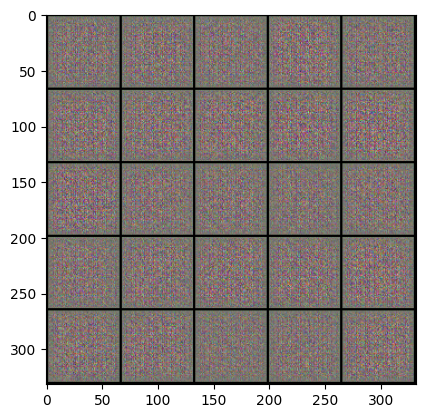

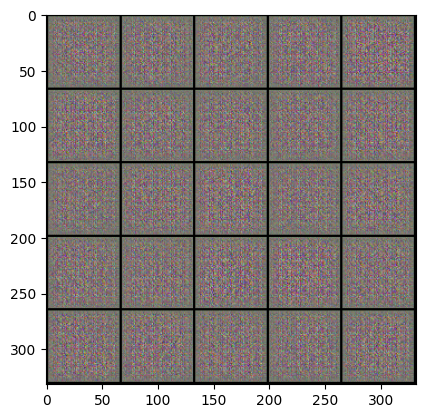

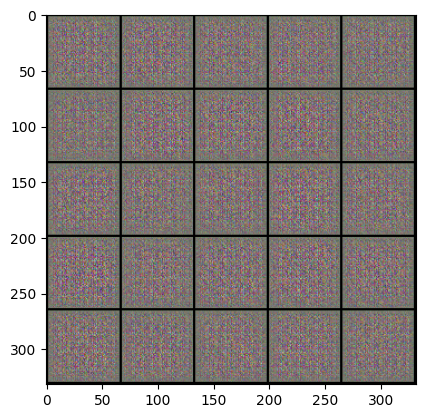

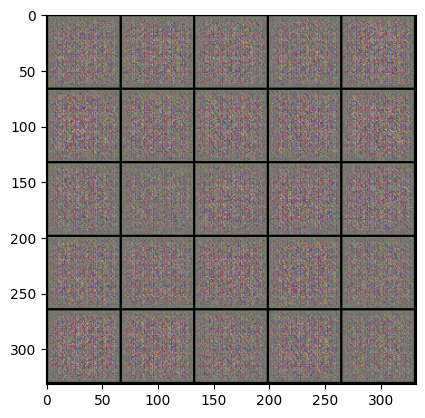

C:\Users\macie\Pulpit\studia\python\GAN\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [155]:
trainer = pl.Trainer(max_epochs=EPOCHS,
                     accelerator='gpu',
                     devices=1,
                     default_root_dir=CHECKPOINTS_DIR,
                     log_every_n_steps=31)
trainer.fit(model, dm)